c:\Users\MEDV3721\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


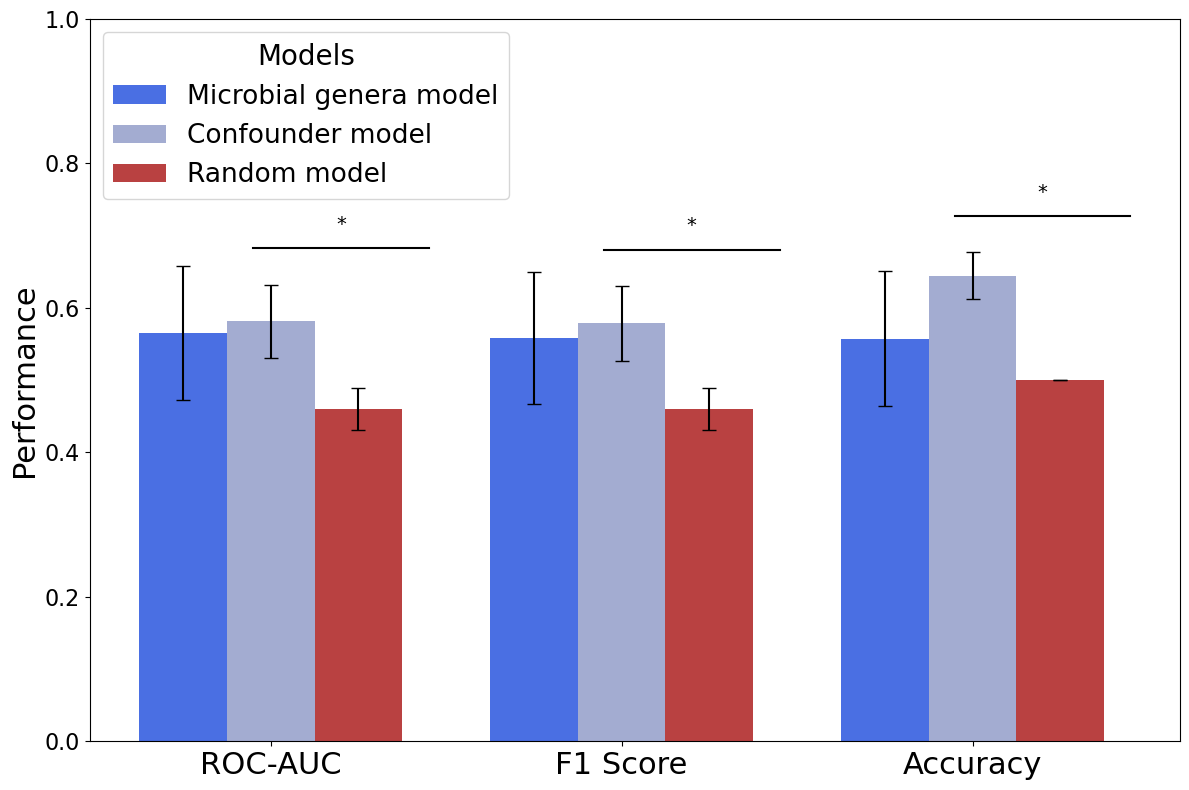

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load data
actual_model_df = pd.read_csv('final_model_results/SFS-CV_RandomForest/performance_metrics_aggregate.csv')
confounders_model_df = pd.read_csv('model_results_confounders/overall_results.csv')
random_baseline_df = pd.read_csv('model_results_random_baseline/avg_random_performance_metrics.csv')

# Extract necessary metrics and calculate mean and standard deviation for each metric
metrics = ['accuracy', 'f1_score', 'roc_auc']

# For SFS-CV_RandomForest (actual model)
actual_model_means = actual_model_df[metrics].mean()
actual_model_stds = actual_model_df[metrics].std()

# For Confounders Model
confounders_model_means = confounders_model_df[metrics].mean()
confounders_model_stds = confounders_model_df[metrics].std()

# For Random Baseline
random_baseline_means = random_baseline_df[metrics].mean()
random_baseline_stds = random_baseline_df[metrics].std()

# Combine the metrics for each model into DataFrames for plotting
mean_df = pd.DataFrame({
    'SFS-CV_RandomForest': actual_model_means,
    'Confounders Model': confounders_model_means,
    'Random Baseline': random_baseline_means
}).T

error_df = pd.DataFrame({
    'SFS-CV_RandomForest': actual_model_stds,
    'Confounders Model': confounders_model_stds,
    'Random Baseline': random_baseline_stds
}).T

# Statistical tests (e.g., t-tests between models)
significance = {}
for metric in metrics:
    # T-test between actual model and random baseline
    t_stat, p_val = stats.ttest_ind(actual_model_df[metric], [random_baseline_means[metric]] * len(actual_model_df[metric]), equal_var=False)
    significance[f"SFS-CV_RandomForest vs Random Baseline - {metric}"] = p_val < 0.05
    
    # T-test between confounders model and random baseline
    t_stat, p_val = stats.ttest_ind(confounders_model_df[metric], [random_baseline_means[metric]] * len(confounders_model_df[metric]), equal_var=False)
    significance[f"Confounders Model vs Random Baseline - {metric}"] = p_val < 0.05
    
    # T-test between actual model and confounders model
    t_stat, p_val = stats.ttest_ind(actual_model_df[metric], confounders_model_df[metric], equal_var=False)
    significance[f"SFS-CV_RandomForest vs Confounders Model - {metric}"] = p_val < 0.05

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define bar width and positions
bar_width = 0.25
x = np.arange(len(metrics))

# Define custom labels
custom_labels = ["Microbial genera model", "Confounder model", "Random model"]

# Plot each model with error bars and colors
colors = ['#4A6FE3', '#A3ACD1', '#B94141']  # Colors for each model (blue, light blue, red)
for i, (model_name, color, custom_label) in enumerate(zip(mean_df.index, colors, custom_labels)):
    ax.bar(x + i * bar_width, mean_df.loc[model_name, :], yerr=error_df.loc[model_name, :], 
           capsize=5, label=custom_label, color=color, width=bar_width)

# Adding significance markers
y_offset = 0.05  # Offset for significance marker
for i, metric in enumerate(metrics):
    if significance[f"SFS-CV_RandomForest vs Random Baseline - {metric}"]:
        y_max = max(mean_df.loc["SFS-CV_RandomForest", metric] + error_df.loc["SFS-CV_RandomForest", metric],
                    mean_df.loc["Random Baseline", metric] + error_df.loc["Random Baseline", metric]) + y_offset
        ax.plot([i - 0.1, i + 0.4], [y_max, y_max], color='black', linewidth=1.5)
        ax.text(i + 0.15, y_max + 0.02, '*', ha='center', va='bottom', color='black', fontsize=14)
    
    if significance[f"Confounders Model vs Random Baseline - {metric}"]:
        y_max = max(mean_df.loc["Confounders Model", metric] + error_df.loc["Confounders Model", metric],
                    mean_df.loc["Random Baseline", metric] + error_df.loc["Random Baseline", metric]) + y_offset
        ax.plot([i + 0.2, i + 0.7], [y_max, y_max], color='black', linewidth=1.5)
        ax.text(i + 0.45, y_max + 0.02, '*', ha='center', va='bottom', color='black', fontsize=14)
    
    if significance[f"SFS-CV_RandomForest vs Confounders Model - {metric}"]:
        y_max = max(mean_df.loc["SFS-CV_RandomForest", metric] + error_df.loc["SFS-CV_RandomForest", metric],
                    mean_df.loc["Confounders Model", metric] + error_df.loc["Confounders Model", metric]) + y_offset
        ax.plot([i, i + 0.5], [y_max + 0.05, y_max + 0.05], color='black', linewidth=1.5)
        ax.text(i + 0.25, y_max + 0.07, '*', ha='center', va='bottom', color='black', fontsize=14)

# Formatting with specific font sizes for clarity
ax.set_xticks(x + bar_width)
ax.set_xticklabels(['ROC-AUC', 'F1 Score', 'Accuracy'], fontsize=22)
ax.set_ylabel("Performance", fontsize=22)
ax.set_ylim(0, 1)  # Assuming all metrics are between 0 and 1
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc="upper left", title="Models", fontsize=19, title_fontsize=20)
#plt.title("Model Performance Comparison", fontsize=24)

plt.tight_layout()
#plt.savefig("model_performance_comparison.png", format='png', dpi=600, bbox_inches='tight')
plt.show()


In [3]:
from scipy.stats import shapiro

normality_results = {}

for model_name, df in models.items():
    normality_results[model_name] = {}
    for metric in metrics:
        stat, p_value = shapiro(df[metric])
        normality_results[model_name][metric] = p_value
        print(f'{model_name} - {metric}: p-value = {p_value:.4f}')

print("\nInterpretation:")
for model_name in normality_results:
    for metric in normality_results[model_name]:
        p_value = normality_results[model_name][metric]
        if p_value > 0.05:
            print(f'{model_name} - {metric}: Normally distributed (p = {p_value:.4f})')
        else:
            print(f'{model_name} - {metric}: Not normally distributed (p = {p_value:.4f})')



SFS-CV_RandomForest - accuracy: p-value = 0.8352
SFS-CV_RandomForest - f1_score: p-value = 0.7136
SFS-CV_RandomForest - roc_auc: p-value = 0.2647
Confounders Model - accuracy: p-value = 0.1866
Confounders Model - f1_score: p-value = 0.1741
Confounders Model - roc_auc: p-value = 0.5411
Random Baseline - accuracy: p-value = 0.5875
Random Baseline - f1_score: p-value = 0.5875
Random Baseline - roc_auc: p-value = 1.0000

Interpretation:
SFS-CV_RandomForest - accuracy: Normally distributed (p = 0.8352)
SFS-CV_RandomForest - f1_score: Normally distributed (p = 0.7136)
SFS-CV_RandomForest - roc_auc: Normally distributed (p = 0.2647)
Confounders Model - accuracy: Normally distributed (p = 0.1866)
Confounders Model - f1_score: Normally distributed (p = 0.1741)
Confounders Model - roc_auc: Normally distributed (p = 0.5411)
Random Baseline - accuracy: Normally distributed (p = 0.5875)
Random Baseline - f1_score: Normally distributed (p = 0.5875)
Random Baseline - roc_auc: Normally distributed (p 

c:\Users\MEDV3721\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


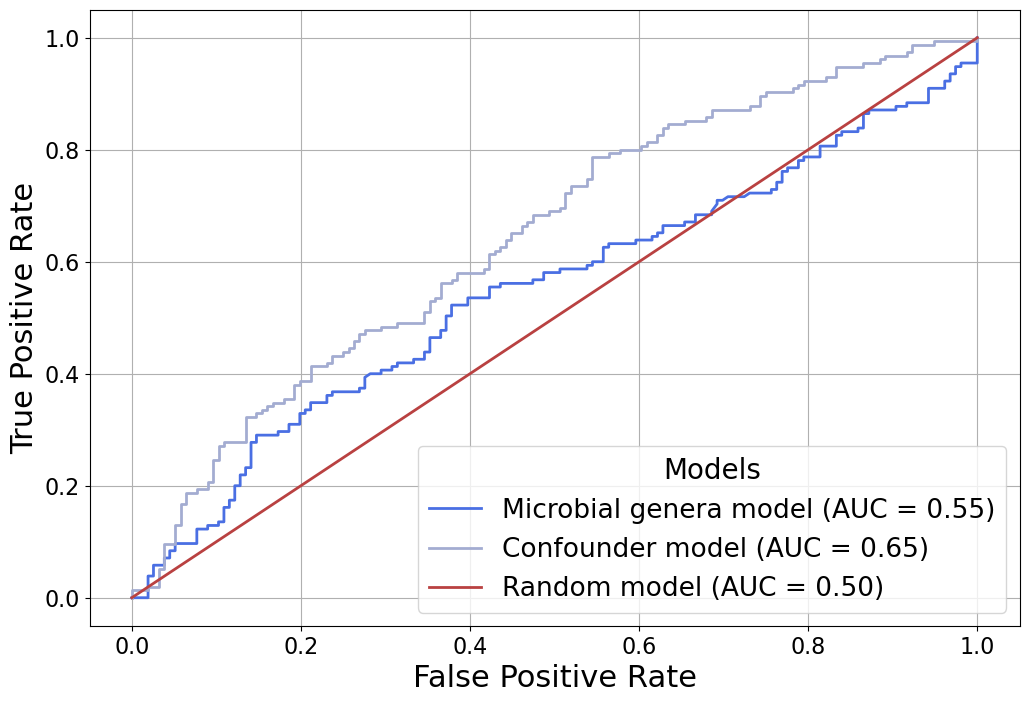

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Paths for each model's predictions
base_path = "model_results_random_baseline/outer_fold_"
confounders_path = "model_results_confounders/outer_fold_"
final_model_path = "final_model_results/SFS-CV_RandomForest/outer_fold_"

# Number of outer folds
num_folds = 5

# Initialize lists to store the true labels and predicted probabilities
y_true_all = []
random_proba_all = []
confounders_proba_all = []
final_proba_all = []

# Loop through each outer fold
for fold in range(1, num_folds + 1):
    # Load random baseline predictions
    random_df = pd.read_csv(f"{base_path}{fold}/predictions_random_trial_{fold}.csv")
    y_true_all.extend(random_df['y_true'].apply(lambda x: 1 if x == 'Better' else 0))
    random_proba_all.extend(random_df['Better'])

    # Load confounders model predictions
    confounders_df = pd.read_csv(f"{confounders_path}{fold}/predictions.csv")
    confounders_proba_all.extend(confounders_df['Better'])

    # Load final model predictions
    final_df = pd.read_csv(f"{final_model_path}{fold}/predictions.csv")
    final_proba_all.extend(final_df['Better'])

# Calculate ROC curves for each model
fpr_random, tpr_random, _ = roc_curve(y_true_all, random_proba_all)
roc_auc_random = auc(fpr_random, tpr_random)

fpr_confounders, tpr_confounders, _ = roc_curve(y_true_all, confounders_proba_all)
roc_auc_confounders = auc(fpr_confounders, tpr_confounders)

fpr_final, tpr_final, _ = roc_curve(y_true_all, final_proba_all)
roc_auc_final = auc(fpr_final, tpr_final)

#colors = ['#4A6FE3', '#A3ACD1', '#B94141']
# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_final, tpr_final, label=f"Microbial genera model (AUC = {roc_auc_final:.2f})", color='#4A6FE3', linewidth=2)
plt.plot(fpr_confounders, tpr_confounders, label=f"Confounder model (AUC = {roc_auc_confounders:.2f})", color='#A3ACD1', linewidth=2)
plt.plot(fpr_random, tpr_random, label=f"Random model (AUC = {roc_auc_random:.2f})", color='#B94141', linewidth=2)

# Plot a diagonal line for reference
#plt.plot([0, 1], [0, 1], 'k--', label="Chance", linewidth=1.5)

# Customize the plot with specific font sizes for clarity
#plt.title("Receiver Operating Characteristic Curve", fontsize=24)
plt.xlabel("False Positive Rate", fontsize=22)
plt.ylabel("True Positive Rate", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="lower right", fontsize=19, title="Models", title_fontsize=20)
plt.grid(True)

# Save the high-resolution figure
plt.savefig("model_ROC_comparison.png", format='png', dpi=600, bbox_inches='tight')
plt.show()



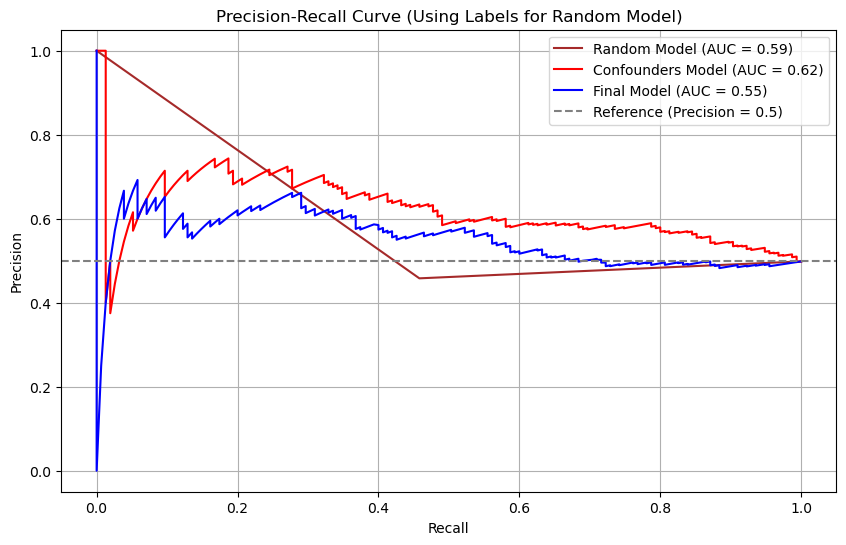

In [ ]:
#NOT USED. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

# Paths for each model's predictions
base_path = "model_results_random_baseline/outer_fold_"
confounders_path = "model_results_confounders/outer_fold_"
final_model_path = "final_model_results/SFS-CV_RandomForest/outer_fold_"

# Number of outer folds
num_folds = 5

# Initialize lists to store the true labels and predicted probabilities for confounders and final models
y_true_all = []
confounders_proba_all = []
final_proba_all = []

# Initialize lists to store random model predictions for label-based precision-recall calculation
y_pred_random_all = []

# Loop through each outer fold
for fold in range(1, num_folds + 1):
    # Load random baseline predictions
    random_df = pd.read_csv(f"{base_path}{fold}/predictions_random_trial_{fold}.csv")
    y_true_all.extend(random_df['y_true'].apply(lambda x: 1 if x == 'Better' else 0))
    y_pred_random_all.extend(random_df['y_pred'].apply(lambda x: 1 if x == 'Better' else 0))

    # Load confounders model predictions
    confounders_df = pd.read_csv(f"{confounders_path}{fold}/predictions.csv")
    confounders_proba_all.extend(confounders_df['Better'])

    # Load final model predictions
    final_df = pd.read_csv(f"{final_model_path}{fold}/predictions.csv")
    final_proba_all.extend(final_df['Better'])

# Calculate Precision-Recall for the random model using labels
precision_random, recall_random, _ = precision_recall_curve(y_true_all, y_pred_random_all)
pr_auc_random = auc(recall_random, precision_random)

# Calculate Precision-Recall curves for the confounders and final models using probabilities
precision_confounders, recall_confounders, _ = precision_recall_curve(y_true_all, confounders_proba_all)
pr_auc_confounders = auc(recall_confounders, precision_confounders)

precision_final, recall_final, _ = precision_recall_curve(y_true_all, final_proba_all)
pr_auc_final = auc(recall_final, precision_final)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_random, precision_random, label=f"Random Model (AUC = {pr_auc_random:.2f})", color='brown')
plt.plot(recall_confounders, precision_confounders, label=f"Confounders Model (AUC = {pr_auc_confounders:.2f})", color='red')
plt.plot(recall_final, precision_final, label=f"Final Model (AUC = {pr_auc_final:.2f})", color='blue')

# Add a reference line at Precision = 0.5
plt.axhline(y=0.5, color='gray', linestyle='--', label="Reference (Precision = 0.5)")

# Customize the plot
plt.title("Precision-Recall Curve (Using Labels for Random Model)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.grid(True)

# Show the plot
plt.show()


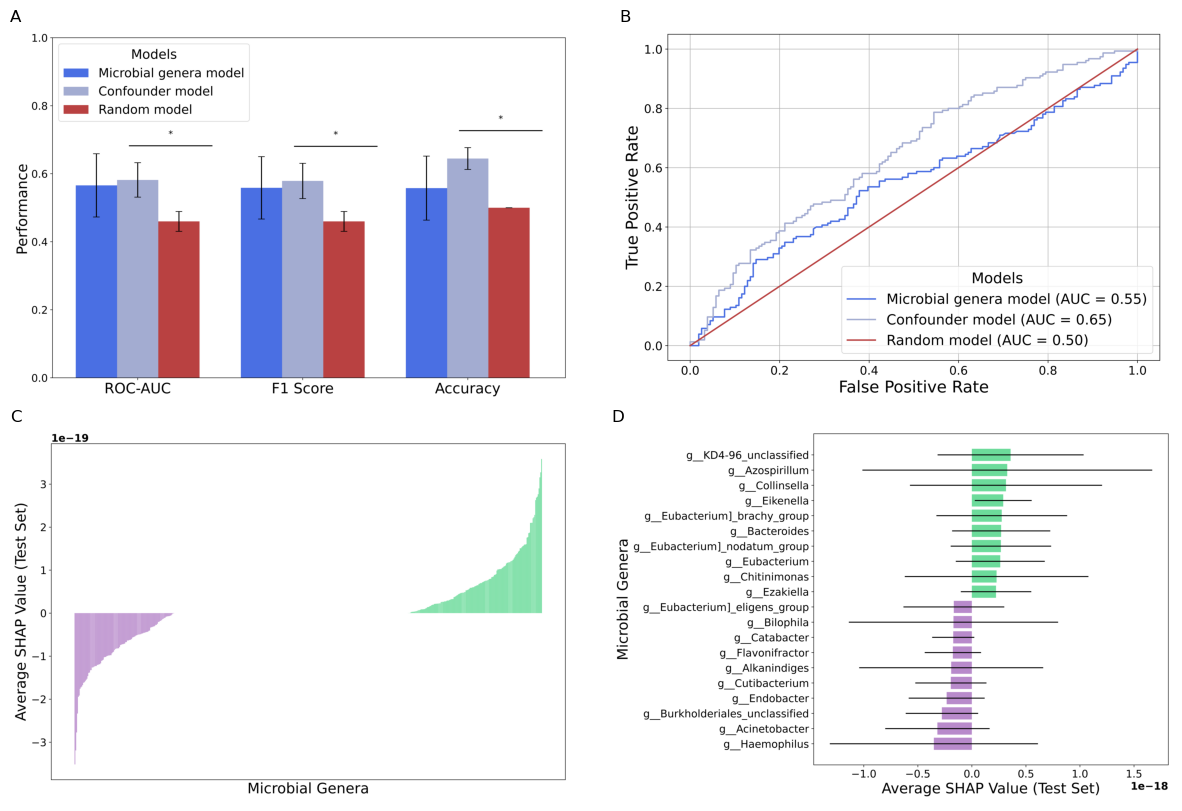

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img1 = mpimg.imread("model_performance_comparison.png")
img2 = mpimg.imread("model_ROC_comparison.png")
img3 = mpimg.imread("shapleys/avg_shap_values_test_plot.png")
img4 = mpimg.imread("shapleys/top_10_shap_values_test_plot.png")

# Define font size and settings for labels
label_fontsize = 14
title_fontsize = 12

# 1. Full 2x2 Composite Figure with All Four Panels (a, b, c, d)
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Display each image in the corresponding subplot and add labels
axs[0, 0].imshow(img1)
axs[0, 0].axis('off')
axs[0, 0].set_title("A", fontsize=title_fontsize, loc='left')

axs[0, 1].imshow(img2)
axs[0, 1].axis('off')
axs[0, 1].set_title("B", fontsize=title_fontsize, loc='left')

axs[1, 0].imshow(img3)
axs[1, 0].axis('off')
axs[1, 0].set_title("C", fontsize=title_fontsize, loc='left')

axs[1, 1].imshow(img4)
axs[1, 1].axis('off')
axs[1, 1].set_title("D", fontsize=title_fontsize, loc='left')

# Save the high-resolution figure with all four panels
plt.savefig("composite_figure_with_all_panels.png", format="png", dpi=600, bbox_inches="tight")

# Display the figure
plt.show()
